# Bert 

In [1]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from os.path import join as joinpath
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertTokenizer, BertModel
from transformers.optimization import get_linear_schedule_with_warmup
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
import copy

In [2]:
plag_dataset = pd.read_csv(joinpath('..', 'plag_dataset.csv'))

In [13]:
print(f'Dataset lenght {len(plag_dataset)}')
plag_dataset.head()

Dataset lenght 1371


,Unnamed: 0,original,untrusted,plagiarism
0,0,public class T1 { public static void main(Str...,import java.util.Scanner; public class Soal1 ...,0
1,1,public class T1 { public static void main(Str...,public class Kasus1L1 { public stati...,1
2,2,public class T1 { public static void main(Str...,public class Kasus1L3 { public stati...,1
3,3,public class T1 { public static void main(Str...,public class Kasus1L6 { public ...,1
4,4,public class T1 { public static void main(Str...,public class L1 { public static void main...,1


In [3]:
train, test = train_test_split(plag_dataset, test_size=0.2, random_state=69)

In [42]:
print(f'Train size: {len(train)}\nTest size: {len(test)}')

Train size: 1096
Test size: 275


## Tokenization
This section is meant to show the tokenization process for the bert transformer

In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [23]:
print(tokenizer)

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


In [29]:
original_string = 'public static void main(String[] args){}'
print(f'Original string: {original_string}')

token_ids = tokenizer.encode(original_string)
print(f'Token IDs: {token_ids}')

tokens = tokenizer.convert_ids_to_tokens(token_ids)
print(f'Tokens: {tokens}')

Original string: public static void main(String[] args){}
Token IDs: [101, 2270, 10763, 11675, 2364, 1006, 5164, 1031, 1033, 12098, 5620, 1007, 1063, 1065, 102]
Tokens: ['[CLS]', 'public', 'static', 'void', 'main', '(', 'string', '[', ']', 'ar', '##gs', ')', '{', '}', '[SEP]']


In [ ]:
sourceCode = plag_dataset['original'].iloc[0]

# With encode_plus we generate both an id an attention mask
# when sequences are padded we need a mask for the attention scores to avoid 
# tokens to be affected by the zeros padding
token_ids = tokenizer.encode_plus(
  sourceCode,
  max_length = 512,
  padding = 'max_length',
  truncation = True,
  return_tensors = 'pt',
)

print('Token IDs:')
print(token_ids['input_ids'])

print('Attention Mask:')
print(token_ids['attention_mask'])


Token IDs:
tensor([[  101,  2270,  2465,  1056,  2487,  1063,  2270, 10763, 11675,  2364,
          1006,  5164,  1031,  1033, 12098,  5620,  1007,  1063,  2291,  1012,
          2041,  1012,  6140, 19666,  1006,  1000,  6160,  2000,  9262,  1000,
          1007,  1025,  2291,  1012,  2041,  1012,  6140, 19666,  1006,  1000,
          6160,  2000,  9262,  1000,  1007,  1025,  2291,  1012,  2041,  1012,
          6140, 19666,  1006,  1000,  6160,  2000,  9262,  1000,  1007,  1025,
          2291,  1012,  2041,  1012,  6140, 19666,  1006,  1000,  6160,  2000,
          9262,  1000,  1007,  1025,  2291,  1012,  2041,  1012,  6140, 19666,
          1006,  1000,  6160,  2000,  9262,  1000,  1007,  1025,  1065,  1065,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     

## Data Loading
We will create an in-memory dataset with the pre-computed ids and attention masks tensors
and another dataset for the pre-generating the BERT embeddings

In [ ]:
class TokenizedDataset(Dataset):
  def __init__(self, df: pd.DataFrame):
    super().__init__()

    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    self.original_ids = []
    self.original_masks = []
    self.untrusted_ids = []
    self.untrusted_masks = []

    # Extract both of the source code samples and the labels
    for _, row in df.iterrows():
      original, untrusted = row['original'], row['untrusted']

      id, mask = self._encode_ids_masks(original)
      self.original_ids.append(id)
      self.original_masks.append(mask)

      id, mask = self._encode_ids_masks(untrusted)
      self.untrusted_ids.append(id)
      self.untrusted_masks.append(mask)

    self.original_ids = torch.cat(self.original_ids, dim=0)
    self.original_masks = torch.cat(self.original_masks, dim=0)
    self.untrusted_ids = torch.cat(self.untrusted_ids, dim=0)
    self.untrusted_masks = torch.cat(self.untrusted_masks, dim=0)
    self.labels = torch.tensor(df['plagiarism'].values)

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return {
      'original_id': self.original_ids[idx],
      'original_mask': self.original_masks[idx],
      'untrusted_id': self.untrusted_ids[idx],
      'untrusted_mask': self.untrusted_masks[idx],
      'label': self.labels[idx],
    }

  def _encode_ids_masks(self, text: str):
    # We pass to the bert tokenizer to get both id tenosrs and attention masks
    encoded = self.tokenizer.encode_plus(
      text,
      max_length = 512,
      padding = 'max_length',
      truncation = True,
      return_tensors = 'pt',
    )

    return encoded['input_ids'], encoded['attention_mask']


In [ ]:
class EmbeddedDataset(Dataset):
  def __init__(self, path):
    # We just read the tensors from a file after generating them (keeps this class less cluttered)
    data = torch.load(path)
    self.originals = data['originals']
    self.untrusted = data['untrusted']
    self.labels = data['labels']

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return {
      'original': self.originals[idx],
      'untrusted': self.untrusted[idx],
      'label': self.labels[idx],
    }

In [ ]:
train_dataset = TokenizedDataset(train)
test_dataset = TokenizedDataset(test)

# GPU memory is limited so we need the loader to give us the data in batches 
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
def embedd_dataset(data_loader: DataLoader):
  # Pre-generate embeddings
  bert = BertModel.from_pretrained('bert-base-uncased')

  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  bert.eval()
  bert.to(device)
  
  all_originals = []
  all_untrusted = []
  all_labels = []
  
  with torch.no_grad():
    for batch in tqdm(data_loader):
      original_ids = batch['original_id'].to(device)
      original_masks = batch['original_mask'].to(device)
      untrusted_ids = batch['untrusted_id'].to(device)
      untrusted_masks = batch['untrusted_mask'].to(device)
  
      # Taking the output embedding for both sequences and store them separatelly 
      # if we decide to use them separatelly
      original_emb = bert(
        input_ids=original_ids,
        attention_mask=original_masks,
      ).pooler_output
  
      untrusted_emb = bert(
        input_ids=untrusted_ids,
        attention_mask=untrusted_masks,
      ).pooler_output

      all_originals.append(original_emb)
      all_untrusted.append(untrusted_emb)

      # Also store the labels 
      all_labels.append(batch['label'])
  
  return all_originals, all_untrusted, all_labels

In [62]:
train_originals, train_untrusted, train_labels = embedd_dataset(train_loader)
test_originals, test_untrusted, test_labels = embedd_dataset(test_loader)

torch.save({
  'originals': torch.cat(train_originals),
  'untrusted': torch.cat(train_untrusted),
  'labels': torch.cat(train_labels),
}, '../train_embeddings.pt')

torch.save({
  'originals': torch.cat(test_originals),
  'untrusted': torch.cat(test_untrusted),
  'labels': torch.cat(test_labels),
}, '../test_embeddings.pt')


100%|██████████| 18/18 [00:10<00:00,  1.73it/s]


In [ ]:
train_embeddings = EmbeddedDataset('../train_embeddings.pt')
test_embeddings = EmbeddedDataset('../test_embeddings.pt')

train_embeddings_loader = DataLoader(train_embeddings, batch_size=16, shuffle=True)
test_embeddings_loader = DataLoader(test_embeddings, batch_size=16)

In [ ]:
# Getting the evaluation metrics also returning a confusion matrix (cm) optionally
@torch.no_grad()
def eval_classifier(classifier: nn.Module, loader: DataLoader, device: str, loss_function=nn.BCEWithLogitsLoss(), get_cm=False):
  classifier.eval()
  all_preds = []
  all_labels = []
  test_loss = 0.0
  total = 0
  
  for batch in loader:
    originals = batch['original'].to(device)
    untrusted = batch['untrusted'].to(device)
    concat = torch.cat((originals, untrusted), dim=1)
    labels = batch['label'].float().unsqueeze(-1).to(device)

    logits = classifier(concat)
        
    loss = loss_function(logits, labels) 
    probs = torch.sigmoid(logits) 
    # Getting all probabilities above 50%
    predictions = (probs > 0.5).int()

    all_preds.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    test_loss += loss.item()
    total += labels.size(0)

  test_accuracy = accuracy_score(all_labels, all_preds)
  f1 = f1_score(all_labels, all_preds)
  recall = recall_score(all_labels, all_preds)
  avg_test_loss = test_loss / max(1, total)
  # Optional confusion
  cm = confusion_matrix(all_labels, all_preds) if get_cm else None

  return {
    'accuracy': test_accuracy,
    'loss': avg_test_loss,
    'f1': f1,
    'recall': recall,
    'cm': cm,
  }

# Train loop for the classifier
def train_classifier(train_loader: DataLoader, test_loader: DataLoader, epochs: int):
  history = {
    'train_accuracy': [],
    'train_loss': [],
    'test_accuracy': [],
    'test_loss': [],
    'f1': [],
    'recall': [],
  }

  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  classifier = nn.Sequential(
    nn.Linear(768 * 2, 512), # 768 * 2 is the size of the two BERT outputs concatenated
    nn.ReLU(),
    nn.Dropout(0.5), # Dropout layers to prevent overfit
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(128, 1),
    # We don't add a final activation function (sigmoid) because we use BCEWithLogitsLoss as a loss function
  )
  
  classifier.to(device)
  
  # Learning rate at 1e-4 to stabilize the training process
  # Also weight decay is pressent to punish huge weights 
  optimizer = AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-4)
  loss_function = nn.BCEWithLogitsLoss()
  
  for epoch in range(0, epochs):
    classifier.train()
    train_loss = 0.0
    correct_preds = 0
    total = 0
    best_test_acc = 0.0
    
    for batch in train_loader:
      originals = batch['original'].to(device)
      untrusted = batch['untrusted'].to(device)
      concat = torch.cat((originals, untrusted), dim=1)
      labels = batch['label'].float().unsqueeze(-1).to(device)
  
      optimizer.zero_grad()
    
      logits = classifier(concat)
      loss = loss_function(logits, labels)
      loss.backward()
      # Prevent exploding gradients by clipping
      torch.nn.utils.clip_grad_norm_(classifier.parameters(), 1.0)
      optimizer.step()
    
      train_loss += loss.item()
      predictions = torch.sigmoid(logits) > 0.5
      correct_preds += (predictions == labels.bool()).sum().item()
      total += labels.size(0)
    
    train_eval_metrics = eval_classifier(classifier, train_loader, device, loss_function)

    # Model evaluation
    avg_loss = train_eval_metrics['loss']
    accuracy = train_eval_metrics['accuracy']
    
    history['train_loss'].append(avg_loss)
    history['train_accuracy'].append(accuracy)
  
    test_eval_metrics = eval_classifier(classifier, test_loader, device, loss_function)
    test_accuracy = test_eval_metrics['accuracy']
    test_loss = test_eval_metrics['loss']
    f1 = test_eval_metrics['f1']
    recall = test_eval_metrics['recall']

    history['test_accuracy'].append(test_accuracy)
    history['test_loss'].append(test_loss)
    history['f1'].append(f1)
    history['recall'].append(recall)

    # Save a copy of the model weights if we achieve a better test accuracy
    if test_accuracy > best_test_acc:
      best_test_acc = test_accuracy
      best_model_state = copy.deepcopy(classifier.state_dict())
      torch.save(best_model_state, '../best_classifier.pt')

    if epoch % 10 == 0:
      print(f'Epoch: {epoch}')
      print(f'(train) Loss: {avg_loss:.4f} | Acc: {accuracy:.4f}')
      print(f'(test) Loss: {test_loss:.4f} | Acc: {test_accuracy:.4f} | F1: {f1:.4f} | Recall: {recall:.4f}')
  
  if best_model_state is not None:
    classifier.load_state_dict(best_model_state)
    print(f'Best test accuracy: {best_test_acc}')
  
  return classifier, history

classifier, history = train_classifier(train_embeddings_loader, test_embeddings_loader, epochs=300)

Epoch: 0
(train) Loss: 0.0412 | Acc: 0.6068
(test) Loss: 0.0439 | Acc: 0.5491 | F1: 0.2250 | Recall: 0.1324
Epoch: 10
(train) Loss: 0.0339 | Acc: 0.7600
(test) Loss: 0.0359 | Acc: 0.7673 | F1: 0.7500 | Recall: 0.7059
Epoch: 20
(train) Loss: 0.0331 | Acc: 0.7719
(test) Loss: 0.0352 | Acc: 0.7673 | F1: 0.7500 | Recall: 0.7059
Epoch: 30
(train) Loss: 0.0325 | Acc: 0.7728
(test) Loss: 0.0346 | Acc: 0.7673 | F1: 0.7500 | Recall: 0.7059
Epoch: 40
(train) Loss: 0.0325 | Acc: 0.7655
(test) Loss: 0.0347 | Acc: 0.7673 | F1: 0.7480 | Recall: 0.6985
Epoch: 50
(train) Loss: 0.0323 | Acc: 0.7774
(test) Loss: 0.0343 | Acc: 0.7709 | F1: 0.7529 | Recall: 0.7059
Epoch: 60
(train) Loss: 0.0314 | Acc: 0.7783
(test) Loss: 0.0327 | Acc: 0.7709 | F1: 0.7623 | Recall: 0.7426
Epoch: 70
(train) Loss: 0.0314 | Acc: 0.7719
(test) Loss: 0.0332 | Acc: 0.7745 | F1: 0.7559 | Recall: 0.7059
Epoch: 80
(train) Loss: 0.0307 | Acc: 0.7874
(test) Loss: 0.0323 | Acc: 0.7782 | F1: 0.7626 | Recall: 0.7206
Epoch: 90
(train) Lo

In [124]:
classifier

Sequential(
  (0): Linear(in_features=1536, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.6, inplace=False)
  (6): Linear(in_features=128, out_features=1, bias=True)
)

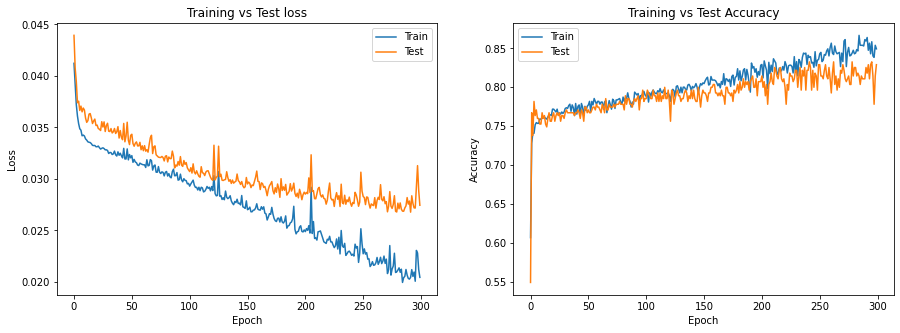

In [125]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['test_loss'], label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Training vs Test loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], label='Train')
plt.plot(history['test_accuracy'], label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy')

plt.show()

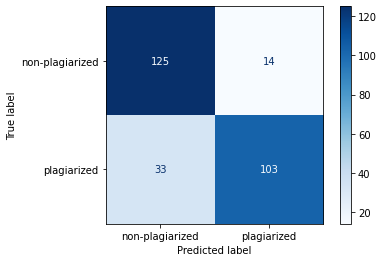

In [126]:
eval_metrics = eval_classifier(classifier, test_embeddings_loader, 'cuda', nn.BCEWithLogitsLoss(), get_cm=True)
disp = ConfusionMatrixDisplay(confusion_matrix=eval_metrics['cm'], display_labels=['non-plagiarized', 'plagiarized'])
disp.plot(cmap='Blues')
plt.show()